In [46]:
import os
import numpy as np
import pandas as pd
import datetime
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import datasets, preprocessing, models, layers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
Data = pd.read_csv('src/data/airquality-dataset/sample_dataset.csv', index_col=0, chunksize=50)

In [3]:
Data.get_chunk().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   channel_id  50 non-null     int64  
 1   pm2_5       50 non-null     float64
 2   pm10        50 non-null     float64
 3   s2_pm2_5    50 non-null     float64
 4   s2_pm10     50 non-null     float64
 5   Site        50 non-null     object 
 6   TimeStamp   50 non-null     object 
dtypes: float64(4), int64(1), object(2)
memory usage: 3.1+ KB


In [4]:
dataType = {'channel_id' : 'uint32',
            'pm2_5' : 'float32',
            'pm10' : 'float32',
            's2_pm2_5' : 'float32',
            's2_pm10' : 'float32',
            'Site' : 'str',
            'TimeStamp' : 'str'
           }

In [5]:
def load_data(dataPath, dataType: dict) -> pd.core.frame.DataFrame:
    data = pd.read_csv(dataPath, dtype=dataType, index_col=0)
    data = data.drop_duplicates(ignore_index=True)
    data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])
    
    return data

In [6]:
data = load_data(dataPath='src/data/airquality-dataset/sample_dataset.csv', dataType=dataType)

/home/usman/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
data.head()

,channel_id,pm2_5,pm10,s2_pm2_5,s2_pm10,Site,TimeStamp
0,912223,37.020000,45.230000,34.070000,39.820000,"Banda, Kampala",2019-11-27 13:24:45
1,912223,41.700001,50.700001,38.549999,47.430000,"Banda, Kampala",2019-11-27 13:26:13
2,912223,42.150002,52.869999,40.549999,49.950001,"Banda, Kampala",2019-11-27 13:30:53
3,912223,45.099998,57.020000,44.750000,55.029999,"Banda, Kampala",2019-11-27 13:32:22
4,912223,41.720001,52.080002,40.000000,49.200001,"Banda, Kampala",2019-11-27 13:33:46


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23530784 entries, 0 to 23530783
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   channel_id  uint32        
 1   pm2_5       float32       
 2   pm10        float32       
 3   s2_pm2_5    float32       
 4   s2_pm10     float32       
 5   Site        object        
 6   TimeStamp   datetime64[ns]
dtypes: datetime64[ns](1), float32(4), object(1), uint32(1)
memory usage: 807.9+ MB


In [9]:
channelSite = dict(zip(data['channel_id'].unique(), data['Site'].unique()))

In [ ]:
#siteGroups = data.groupby('channel_id')

In [ ]:
# for x in siteGroups.groups:
#     if not os.path.exists('data_group'):
#         os.makedirs('data_group')
#     siteGroups.get_group(x).to_csv(f'data_group/{x}.csv')

In [10]:
def readChannel(channelId: int, dataPath='src/data/data_group/') -> pd.core.frame.DataFrame:
    path = dataPath + str(channelId) + '.csv'
    channelData = pd.read_csv(path, index_col=0, parse_dates=['TimeStamp'])
    return channelData

In [36]:
channel_one = readChannel(channelId=list(channelSite.keys())[0])

In [37]:
channel_one_copy = channel_one.set_index(['TimeStamp'])

In [20]:
def getFeatures(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    
    df = df.drop(labels='channel_id', axis=1).set_index(['TimeStamp']).resample('H').mean().fillna(method='ffill')
    #df = df.drop(labels='channel_id', axis=1).groupby(pd.Grouper(key='TimeStamp', freq='1H')).mean().fillna(method='ffill')
    df = df.assign(hour = df.index.hour,
                   day = df.index.day,
                   month = df.index.month,
                   day_of_week = df.index.dayofweek,
                   week_of_year = df.index.week)
    
    return df

def generate_cyclical_features(df: pd.core.frame.DataFrame, col_name: list) -> pd.core.frame.DataFrame:
    
    
    for time_col in col_name:
        kwargs = {
            f'sin_{time_col}' :lambda x: np.sin(2*np.pi*(x[time_col] - x[time_col].min()) / x[time_col].nunique()),
            f'cos_{time_col}' :lambda x: np.cos(2*np.pi*(x[time_col] - x[time_col].min()) / x[time_col].nunique())    
                 }
        df_time = df.assign(**kwargs)[['sin_'+time_col, 'cos_'+time_col]]
        
        df = pd.concat([df, df_time], axis=1)
    
    return df

def oneHotEncoding(df: pd.core.frame.DataFrame, col_name:list) -> pd.core.frame.DataFrame:
    
    return pd.get_dummies(data=df, columns=col_name, drop_first=True)

def preprocess(df, col_list=['hour', 'day', 'month', 'day_of_week', 'week_of_year']):

    df = getFeatures(df)
    df = generate_cyclical_features(df, col_list)
    df = oneHotEncoding(df, col_list)

    return df

In [21]:
target=['pm2_5', 'pm10', 's2_pm2_5', 's2_pm10']

In [29]:
points = 10000

<Figure size 1008x720 with 0 Axes>

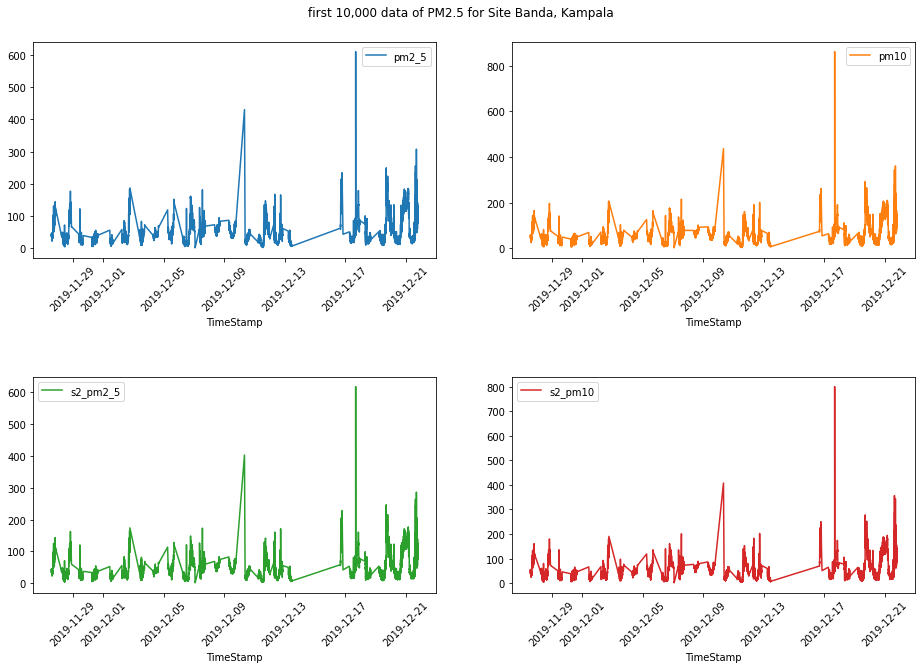

In [32]:
fig = plt.figure(figsize=(14,10))
channel_one_copy[:points].drop('channel_id', axis=1).plot(subplots=True, layout=(2,2), figsize=(14,10), sharex=False, 
                                                    rot=45, 
                                                    title='first 10,000 data of PM2.5 for Site Banda, Kampala')
plt.tight_layout(pad=5)
plt.savefig('pm2_5_data_plot.png')

In [87]:
channel_one_copy.head()

,channel_id,pm2_5,pm10,s2_pm2_5,s2_pm10,Site
TimeStamp,,,,,,
2019-11-27 13:24:45,912223,37.02,45.23,34.07,39.82,"Banda, Kampala"
2019-11-27 13:26:13,912223,41.70,50.70,38.55,47.43,"Banda, Kampala"
2019-11-27 13:30:53,912223,42.15,52.87,40.55,49.95,"Banda, Kampala"
2019-11-27 13:32:22,912223,45.10,57.02,44.75,55.03,"Banda, Kampala"
2019-11-27 13:33:46,912223,41.72,52.08,40.00,49.20,"Banda, Kampala"


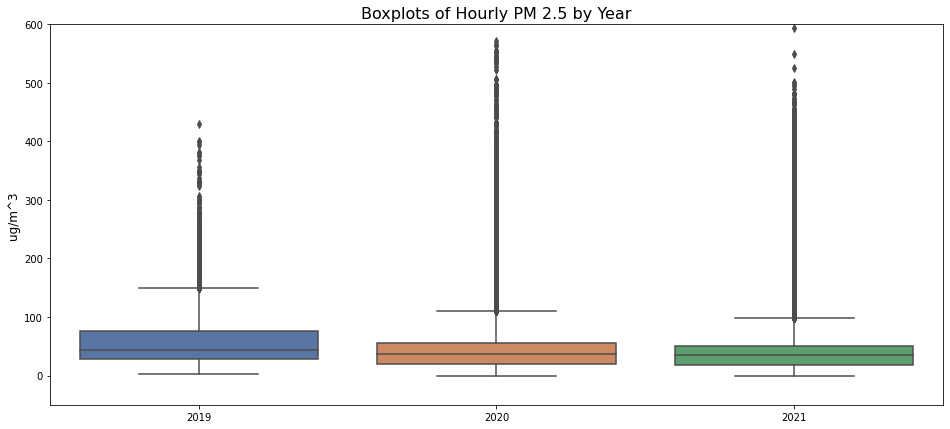

In [89]:
plt.figure(figsize=(16,7))

ax=sns.boxplot(x=channel_one_copy.index.year, y='pm2_5', data=channel_one_copy, orient='v', palette = sns.color_palette("deep", 5))
ax.set(ylim=(-50, 600))

plt.title('Boxplots of Hourly PM 2.5 by Year', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

In [33]:
channel_one_hourly = channel_one_copy
.drop('channel_id', axis=1).resample('H').mean().fillna(method='ffill')

In [34]:
channel_one_hourly.head()

,pm2_5,pm10,s2_pm2_5,s2_pm10
TimeStamp,,,,
2019-11-27 13:00:00,41.258947,51.221579,39.366842,48.085263
2019-11-27 14:00:00,35.883077,43.583846,33.868718,39.694359
2019-11-27 15:00:00,40.329231,49.360769,38.259744,46.074359
2019-11-27 16:00:00,79.226667,90.660238,73.879048,84.298810
2019-11-27 17:00:00,81.079250,90.701000,75.360000,84.586750


In [38]:
channel_one_preprocessed = preprocess(channel_one)

In [55]:
def featureLabelSplit(df, target=target[0]) -> tuple:
    Y = df[target].to_numpy()
    X = df.to_numpy()
    return (X, Y)


def data_split(X, Y, test_ratio=0.3):
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=test_ratio, shuffle=False)
    return X_train, Y_train, X_val, Y_val

In [58]:
Y_train.shape

(12091,)

In [60]:
X, Y = featureLabelSplit(channel_one_preprocessed)

scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_train, Y_train, X_val, Y_val = data_split(X, Y)

X_train = scaler_X.fit_transform(X_train)
Y_train = scaler_Y.fit_transform(Y_train.reshape(-1,1))
X_val = scaler_X.transform(X_val)
Y_val = scaler_Y.transform(Y_val.reshape(-1,1))

In [61]:
batch_size = 1024
test_batch_size = 64

In [63]:
Y_train.reshape(-1,1).shape

(12091, 1)

In [64]:
batch_train = TimeseriesGenerator(data=X_train, targets=Y_train.reshape(
    -1, 1), length=24, sampling_rate=1, batch_size=batch_size)

batch_val = TimeseriesGenerator(data=X_val, targets=Y_val.reshape(
    -1, 1), length=24, sampling_rate=1, batch_size=test_batch_size)

In [72]:
nn_model = models.Sequential([
    layers.Dense(100, input_shape=(batch_train[0][0].shape[1:]), activation='relu'),
    layers.Flatten(),
    layers.Dense(1)
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24, 100)           13700     
                                                                 
 flatten (Flatten)           (None, 2400)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2401      
                                                                 
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
nn_model.compile(optimizer='adam', loss='mse')

In [75]:
epoch = 150

In [76]:
history_NN = nn_model.fit(batch_train, epochs=epoch,
                    validation_data=batch_val, validation_freq=1, workers=2)

Epoch 1/150
12/12 [==============================] - 3s 96ms/step - loss: 0.0576 - val_loss: 0.0290
Epoch 2/150
12/12 [==============================] - 1s 86ms/step - loss: 0.0241 - val_loss: 0.0235
Epoch 3/150
12/12 [==============================] - 1s 73ms/step - loss: 0.0179 - val_loss: 0.0172
Epoch 4/150
12/12 [==============================] - 1s 82ms/step - loss: 0.0104 - val_loss: 0.0086
Epoch 5/150
12/12 [==============================] - 1s 83ms/step - loss: 0.0082 - val_loss: 0.0087
Epoch 6/150
12/12 [==============================] - 1s 79ms/step - loss: 0.0067 - val_loss: 0.0101
Epoch 7/150
12/12 [==============================] - 1s 82ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 8/150
12/12 [==============================] - 1s 80ms/step - loss: 0.0053 - val_loss: 0.0067
Epoch 9/150
12/12 [==============================] - 1s 107ms/step - loss: 0.0051 - val_loss: 0.0061
Epoch 10/150
12/12 [==============================] - 1s 89ms/step - loss: 0.0043 - val_loss: 0.005

12/12 [==============================] - 1s 106ms/step - loss: 6.7278e-04 - val_loss: 0.0042
Epoch 82/150
12/12 [==============================] - 1s 87ms/step - loss: 7.1119e-04 - val_loss: 0.0044
Epoch 83/150
12/12 [==============================] - 1s 91ms/step - loss: 8.0697e-04 - val_loss: 0.0041
Epoch 84/150
12/12 [==============================] - 1s 73ms/step - loss: 7.5047e-04 - val_loss: 0.0048
Epoch 85/150
12/12 [==============================] - 1s 74ms/step - loss: 7.4656e-04 - val_loss: 0.0048
Epoch 86/150
12/12 [==============================] - 1s 78ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 87/150
12/12 [==============================] - 1s 83ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 88/150
12/12 [==============================] - 1s 78ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 89/150
12/12 [==============================] - 1s 85ms/step - loss: 6.2158e-04 - val_loss: 0.0039
Epoch 90/150
12/12 [==============================] - 1s 89ms/step - loss: 4.83

RNN

In [68]:
rnn_model = models.Sequential([
    layers.SimpleRNN(100, input_shape=(batch_train[0][0].shape[1:]), dropout=0.5, recurrent_dropout=0.5),
    layers.Dense(1)
])
print(rnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               23700     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 23,801
Trainable params: 23,801
Non-trainable params: 0
_________________________________________________________________
None


In [85]:
rnn_model.compile(optimizer='adam', loss='mse')
history_RNN = rnn_model.fit(batch_train, epochs=epoch,
                    validation_data=batch_val, validation_freq=1, workers=2)

Epoch 1/150
12/12 [==============================] - 4s 163ms/step - loss: 0.4592 - val_loss: 0.0470
Epoch 2/150
12/12 [==============================] - 2s 180ms/step - loss: 0.1493 - val_loss: 0.0182
Epoch 3/150
12/12 [==============================] - 2s 142ms/step - loss: 0.0653 - val_loss: 0.0112
Epoch 4/150
12/12 [==============================] - 2s 172ms/step - loss: 0.0460 - val_loss: 0.0087
Epoch 5/150
12/12 [==============================] - 2s 186ms/step - loss: 0.0407 - val_loss: 0.0058
Epoch 6/150
12/12 [==============================] - 2s 149ms/step - loss: 0.0360 - val_loss: 0.0049
Epoch 7/150
12/12 [==============================] - 2s 146ms/step - loss: 0.0357 - val_loss: 0.0048
Epoch 8/150
12/12 [==============================] - 2s 197ms/step - loss: 0.0326 - val_loss: 0.0041
Epoch 9/150
12/12 [==============================] - 2s 199ms/step - loss: 0.0309 - val_loss: 0.0039
Epoch 10/150
12/12 [==============================] - 2s 197ms/step - loss: 0.0298 - val_lo

12/12 [==============================] - 2s 167ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 82/150
12/12 [==============================] - 2s 162ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 83/150
12/12 [==============================] - 2s 154ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 84/150
12/12 [==============================] - 2s 142ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 85/150
12/12 [==============================] - 2s 172ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 86/150
12/12 [==============================] - 2s 142ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 87/150
12/12 [==============================] - 2s 132ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 88/150
12/12 [==============================] - 2s 182ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 89/150
12/12 [==============================] - 2s 165ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 90/150
12/12 [==============================] - 2s 147ms/step - loss: 0.0025 - val_loss: 

LSTM

In [69]:
lstm_model = models.Sequential([
    layers.Bidirectional(layers.LSTM(100, return_sequences=True, recurrent_dropout=0.5), input_shape=(batch_train[0][0].shape[1:])),
    layers.Bidirectional(layers.LSTM(100, recurrent_dropout=0.5)),
    layers.Dense(1)
])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 24, 200)          189600    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 430,601
Trainable params: 430,601
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
lstm_model.compile(optimizer='adam', loss='mse')
history_LSTM = lstm_model.fit(batch_train, epochs=epoch,
                    validation_data=batch_val, validation_freq=1, workers=2)